In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, StratifiedKFold

from sklearn.ensemble import GradientBoostingClassifier

In [2]:
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

## 📌 Loss-Funktion & Funktionsweise von `GradientBoostingClassifier` (binär)

### 🔢 Verwendete Loss-Funktion

- Es wird der **Log-Loss** verwendet, also der Fehler aus der **logistischen Regression**:
  
  ```math
  L(y, p) = - \left[ y \cdot \log(p) + (1 - y) \cdot \log(1 - p) \right]
  ```

- Dabei ist \( y \in \{0, 1\} \) das echte Label und \( p \) die vorhergesagte Wahrscheinlichkeit.

---

### ⚙️ Funktionsweise (vereinfacht)

1. Das Modell startet mit einer **Konstanten** (z. B. Durchschnitts-Log-Odds).
2. In jeder Iteration:
   - Berechne die **Vorhersagewahrscheinlichkeit**:
     ```math
     p = \frac{1}{1 + e^{-F(x)}}
     ```
   - Berechne den **Fehler (Gradient)**:
     ```math
     r = y - p
     ```
   - Trainiere einen kleinen Entscheidungsbaum, der diesen Fehler \( r \) approximiert.
   - Aktualisiere das Modell:
     ```math
     F_{\text{neu}}(x) = F_{\text{alt}}(x) + \eta \cdot \text{Baum}(x)
     ```
3. Am Ende werden die Scores mit der Sigmoid-Funktion in Wahrscheinlichkeiten umgewandelt.

---

### ✅ Ziel

- **Minimiere den Log-Loss**, indem du schrittweise Bäume hinzufügst, die die verbleibenden Fehler korrigieren.


In [11]:
inner_cv = StratifiedKFold(n_splits = 3, shuffle=True,random_state=42)
outer_cv = StratifiedKFold(n_splits = 10, shuffle=True,random_state=42)

In [12]:
hyperparams_GB = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
}

grid_GB = GridSearchCV(
    estimator=GradientBoostingClassifier(),
    param_grid=hyperparams_GB,
    scoring='roc_auc',  # Beispiel für mehrklassige AUC
    cv=inner_cv,                     # innere CV (z.B. 3-fach)
)
scores_GB = cross_validate(grid_GB, X=X, y=y, cv=outer_cv, scoring=["roc_auc", "accuracy"], return_train_score=True)

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y 

In [13]:
df = pd.DataFrame(scores_GB)

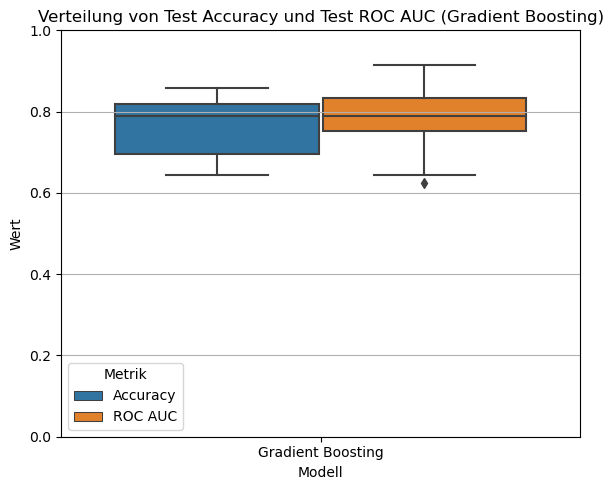

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plot_data = pd.DataFrame({
    'Metrik': ['Accuracy'] * len(df) + ['ROC AUC'] * len(df),
    'Wert': list(df['test_accuracy']) + list(df['test_roc_auc']),
    'Modell': ['Gradient Boosting'] * (2 * len(df))  # Dummy-Spalte für konsistente X-Achse
})

# Plot
plt.figure(figsize=(6, 5))
sns.boxplot(data=plot_data, x='Modell', y='Wert', hue='Metrik')

plt.title('Verteilung von Test Accuracy und Test ROC AUC (Gradient Boosting)')
plt.ylim(0.0, 1.0)
plt.grid(axis='y')
plt.legend(title='Metrik', loc='lower left')
plt.tight_layout()
plt.show()


In [15]:
model_evaluation = pd.DataFrame({"Fold": range(1, 11)})
model_evaluation['Modell'] = ['Gradient Boosting'] * 10
model_evaluation['ROC AUC'] = df['test_roc_auc']
model_evaluation['Accuracy'] = df['test_accuracy']
model_evaluation

,Fold,Modell,ROC AUC,Accuracy
0,1,Gradient Boosting,0.772222,0.827586
1,2,Gradient Boosting,0.855556,0.793103
2,3,Gradient Boosting,0.811111,0.793103
3,4,Gradient Boosting,0.777778,0.655172
4,5,Gradient Boosting,0.802778,0.827586
5,6,Gradient Boosting,0.915205,0.785714
6,7,Gradient Boosting,0.842105,0.857143
7,8,Gradient Boosting,0.643275,0.642857
8,9,Gradient Boosting,0.746875,0.750000
9,10,Gradient Boosting,0.625000,0.678571


In [16]:
model_evaluation.to_pickle('model_evaluation/Gradient_Boosting.pkl')

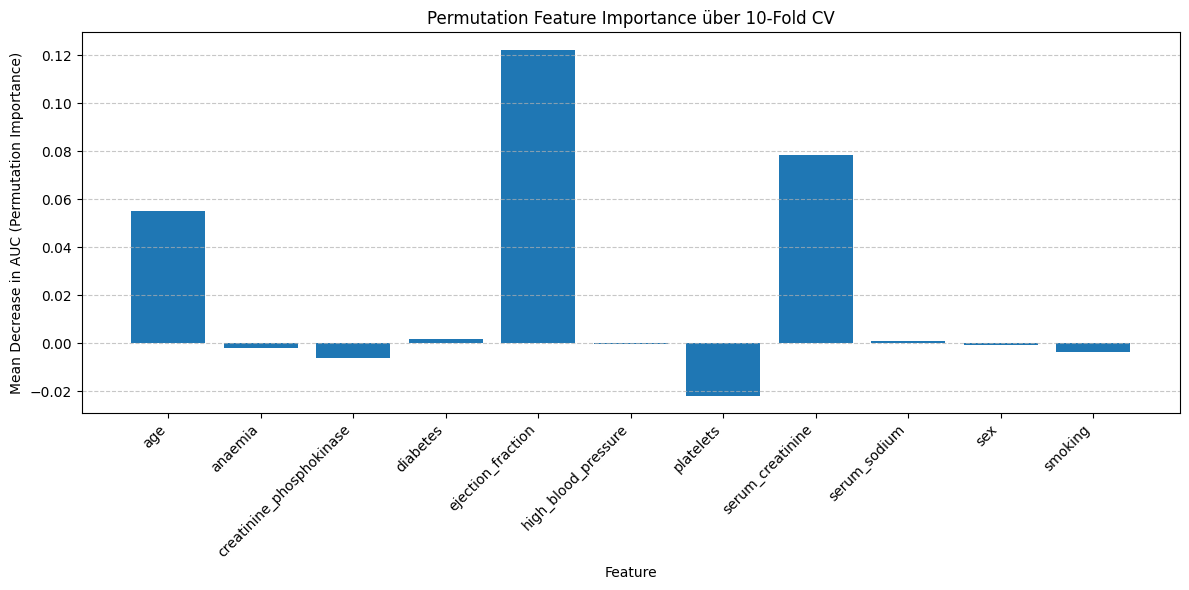

                     Feature  MeanImportance  StdImportance
0                        age        0.054967       0.055713
1                    anaemia       -0.001754       0.005263
2   creatinine_phosphokinase       -0.006129       0.018740
3                   diabetes        0.001725       0.003713
4          ejection_fraction        0.122416       0.071943
5        high_blood_pressure       -0.000312       0.000937
6                  platelets       -0.021734       0.029530
7           serum_creatinine        0.078408       0.075731
8               serum_sodium        0.000786       0.023983
9                        sex       -0.000694       0.004270
10                   smoking       -0.003480       0.008745


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score
from collections import defaultdict

# Feature-Namen aus DataFrame
feature_names = list(X.columns)

# Konvertiere X und y in NumPy-Arrays
X = X.to_numpy()
y_zero_one = y['death_event'].to_numpy()


def model_fitting(X, y, feature_names):
    hyperparams_GB = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    }
    
    outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    outer_scores = []
    perm_importances = defaultdict(list)  # feature index -> list of AUC drops
    
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        grid_GB = GridSearchCV(
            estimator=GradientBoostingClassifier(),
            param_grid=hyperparams_GB,
            scoring='roc_auc',  # Beispiel für mehrklassige AUC
            cv=inner_cv,                     # innere CV (z.B. 3-fach)
        )

        grid_GB.fit(X_train, y_train)
        best_model = grid_GB.best_estimator_
        
        # Baseline AUC auf Testdaten (nutze predict_proba)
        y_score_test = best_model.predict_proba(X_test)[:, 1]  # Nur Klasse 1
        auc_baseline = roc_auc_score(y_test, y_score_test)
        outer_scores.append(auc_baseline)
        
        # Permutation Feature Importance (AUC-Drop)
        for i in range(X_test.shape[1]):
            X_test_permuted = X_test.copy()
            X_test_permuted[:, i] = np.random.permutation(X_test_permuted[:, i])
            y_score_perm = best_model.predict_proba(X_test_permuted)[:, 1]
            auc_perm = roc_auc_score(y_test, y_score_perm)
            perm_importances[i].append(auc_baseline - auc_perm)
    
    # Durchschnittliche Importance pro Feature über alle Folds
    mean_importances = np.array([np.mean(perm_importances[i]) for i in range(X.shape[1])])
    std_importances = np.array([np.std(perm_importances[i]) for i in range(X.shape[1])])
    
    # DataFrame für Übersicht
    df_importances = pd.DataFrame({
        'Feature': feature_names,
        'MeanImportance': mean_importances,
        'StdImportance': std_importances
    })#.sort_values(by='MeanImportance', ascending=False).reset_index(drop=True)
    
    # Visualisierung
    plt.figure(figsize=(12, 6))
    plt.bar(df_importances['Feature'], df_importances['MeanImportance'])
    plt.xlabel('Feature')
    plt.ylabel('Mean Decrease in AUC (Permutation Importance)')
    plt.title('Permutation Feature Importance über 10-Fold CV')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return outer_scores, df_importances

# Beispiel-Aufruf
outer_scores, df_importances = model_fitting(X, y_zero_one, feature_names)
print(df_importances)

In [5]:
df_feature_selection = pd.DataFrame({
    'Feature': feature_names,
    'average decrease in AUC': df_importances["MeanImportance"]
})
print(df_feature_selection)
df_feature_selection.to_pickle('feature_importance/GD.pkl')

                     Feature  average decrease in AUC
0                        age                 0.054967
1                    anaemia                -0.001754
2   creatinine_phosphokinase                -0.006129
3                   diabetes                 0.001725
4          ejection_fraction                 0.122416
5        high_blood_pressure                -0.000312
6                  platelets                -0.021734
7           serum_creatinine                 0.078408
8               serum_sodium                 0.000786
9                        sex                -0.000694
10                   smoking                -0.003480
